# Problem 19: Application of a Groundwater Flow Model to a Water Supply Problem

In [1]:
#Import and modules/packages that we need to work with
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import flopy

In [89]:
#Store the values of each parameter into separate variables
inh = 0.0 #initial head
hk = .3*86400 #hydraulic conductivity ft^2/day
s = 0.06 #storage coefficient
delr = 100 #grid spacing (uniform)
delc = delr
pr = -.963/7.48*86400 #pumping rate ft^3/day
perlen = 1.5 #stress period length in days
nstp = 10 #number of time steps
tsmult = 1.414 #time step multiplier
sip_it_par = 5 # iteration parameters
mxiter = 50 #maximum number of iterations
accel_par = 1.0 #acceleration parameter
hclose = 0.001 #closure criterion (the head change criterion for convergence)
top = 0
botm = -1
nper = 1
laytyp = 0
ipakcb = 50

#grid 44 rows, 55 cols, 1 layer
nlay = 1 #number of layers
nrow = 44 #number of rows
ncol = 55 #number of columns

#riv package
rstage = 0.0 #river stage
rcond = 1728 #river conductance in ft^2/day
rbot = -10 #river bottom

print(pr)

-11123.422459893047


In [90]:
#Flopy objects
modelname = 'p19' #short for problem 19
exe_name = '../MF2005.1_12/bin/mf2005.exe'
model_ws = 'temp'
mf = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws = model_ws)

In [91]:
#call in the discretization package
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=top, botm=botm, nper=nper, perlen=perlen, 
                               nstp=nstp, tsmult=tsmult, steady=False)

In [92]:
#call in the basic package
ibound = np.ones((nlay, nrow, ncol))
strt = 0.0
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

In [148]:
#call in the layer-propery flow (LPF)
model_boundary = pd.read_csv('../Data/problem19_bcf.csv')

lpf = flopy.modflow.ModflowLpf(mf, hk=hk, ss=s, laytyp=laytyp, ipakcb=ipakcb, filenames='../Data/problem19_bcf.csv')


****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...


In [125]:
#call in the well package (WEL)
# Remember to use zero-based layer, row, column indices!
wel_sp1 = [[0, 27, 31, pr], [0, 27, 31, pr], [0, 28, 34, pr], [0, 30, 31, pr]]
wel_spd = {0: wel_sp1}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...


In [126]:
#call in the preconditioned conjugate-gradient package (PCG) 
pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, hclose=hclose)


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfpcg.ModflowPcg'> <class 'flopy.modflow.mfpcg.ModflowPcg'>
replacing existing Package...


In [127]:
#call in the output control package (OC)
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0, 0): ['save head', 'print budget', 'save budget']})


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...


In [151]:
#call in the river package (RIV)
#riv_boundary = pd.read_csv('../Data/problem19_riv.csv')
#riv_sp1
riv = flopy.modflow.ModflowRiv(mf, ipakcb=ipakcb, filename='../Data/problem19_riv.csv')

In [152]:
# Write the MODFLOW model input files
mf.write_input()

# Run the MODFLOW model
success, buff = mf.run_model()

FileNotFoundError: [Errno 2] No such file or directory: 'temp\\../Data/problem19_bcf.csv'

In [153]:
import flopy.utils.binaryfile as bf

# Create the headfile object
fname = os.path.join(model_ws, 'p19.hds') #"os.path.join" joins together the modelname and the .hds file and stores it in fname
headobj = bf.HeadFile(fname) #create headobj and put values from fname (aka 'p1_pa.hds') inside it
times = headobj.get_times() #assign the headobj values to the variable "times"
print(times) #prints the time at each stress period

#print hydraulic head (Table 14.2)
idx = (0, 28, 31) #(nlay, nrow, ncol) *remember you have to subtract 1 from the original numbers for python - (1, 10, 12)*
ts = headobj.get_ts([idx])
print(ts)

[0.020063508, 0.048433311, 0.088548213, 0.14527068, 0.22547624, 0.33888692, 0.49924961, 0.72600245, 1.046631, 1.4999998]
[[ 0.02006351 -0.06134772]
 [ 0.04843331 -0.12902786]
 [ 0.08854821 -0.19204876]
 [ 0.14527068 -0.25039876]
 [ 0.22547624 -0.30539647]
 [ 0.33888692 -0.35807508]
 [ 0.49924961 -0.40915552]
 [ 0.72600245 -0.45918128]
 [ 1.04663098 -0.50869167]
 [ 1.49999976 -0.55846226]]


(0, 0.55846226)

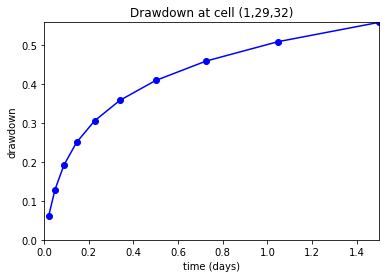

In [154]:
# Plot the drawdown versus time
plt.subplot(1, 1, 1)
ttl = 'Drawdown at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 
plt.plot(ts[:, 0], 0-ts[:, 1], 'bo-') #(x, y, color/type of line)
plt.xlim(0, ts[:, 0].max())
plt.ylim(0, (0-ts[:, 1]).max())

(-0.55846226, -0.061347716)

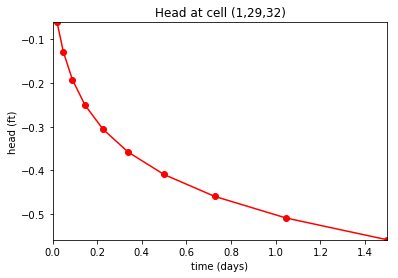

In [155]:
# Plot the head versus time
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time (days)')
plt.ylabel('head (ft)')
plt.plot(ts[:, 0], ts[:, 1], 'ro-')
plt.xlim(0, ts[:, 0].max())
plt.ylim(ts[:, 1].min(), ts[:, 1].max())

In [156]:
#create different variables for each well so that you can plot them
table2 = pd.read_csv('../Data/table19.2.csv')
print(table2)

well1=table2.ix[0:, ['Time (min)', 'Observation Well 1']]
print(well1)

well2=table2.ix[0:, ['Time (min)', 'Observation Well 2']]
print(well2)

well3=table2.ix[0:, ['Time (min)', 'Observation Well 3']]
print(well3)

   Time (min)  Observation Well 1  Observation Well 2  Observation Well 3
0           1                0.17                0.04                0.00
1           4                0.26                0.12                0.01
2          10                0.33                0.16                0.02
3          40                0.48                0.22                0.08
4         100                0.57                0.29                0.14
5         400                0.79                0.51                0.30
6        1000                0.99                0.70                0.50
7        2000                1.19                0.86                0.68
8        3000                1.33                0.98                0.78
   Time (min)  Observation Well 1
0           1                0.17
1           4                0.26
2          10                0.33
3          40                0.48
4         100                0.57
5         400                0.79
6        1000         

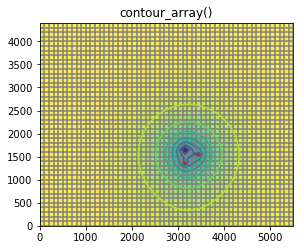

In [164]:
fname = os.path.join(modelname, 'p19.cbc')
head = headobj.get_data(totim=times[-1])
levels = np.linspace(head.min(), head.max(), 10)

fig = plt.figure(figsize=(10, 10))

#plot_array
ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.set_title('contour_array()')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5)
modelmap.plot_bc("WEL")
modelmap.plot_bc("RIV", color='m')
linecollection = modelmap.plot_grid()
contour_set = modelmap.contour_array(head, masked_values=[999.], levels=levels)



### Model Data

In [158]:
# *remember you have to subtract 1 from the original numbers for python*
#well 1 (28, 32)
idx1 = (0, 27, 31) #(nlay, nrow, ncol)

#well 2 (29, 35)
idx2 = (0, 28, 34)

#well 3 (31, 32)
idx3 = (0, 30, 31)

ts = headobj.get_ts([idx1, idx2, idx3])
print(ts)
#prints out time, and the rate of drawdown at well 1, well 2, and well 3

[[ 0.02006351 -0.21058066 -0.10732538 -0.10850215]
 [ 0.04843331 -0.31176817 -0.16464731 -0.16761303]
 [ 0.08854821 -0.37952    -0.21067849 -0.21529832]
 [ 0.14527068 -0.43701646 -0.25595823 -0.26183221]
 [ 0.22547624 -0.49061659 -0.30216527 -0.30891708]
 [ 0.33888692 -0.54218894 -0.34906727 -0.35641897]
 [ 0.49924961 -0.59248132 -0.39632154 -0.40409279]
 [ 0.72600245 -0.6419428  -0.44377589 -0.45188746]
 [ 1.04663098 -0.69100374 -0.49153852 -0.50004441]
 [ 1.49999976 -0.74032032 -0.54013574 -0.54924798]]


### Measured Data

In [136]:
well_data=np.array(table2)
print(well_data)

[[  1.00000000e+00   1.70000000e-01   4.00000000e-02   0.00000000e+00]
 [  4.00000000e+00   2.60000000e-01   1.20000000e-01   1.00000000e-02]
 [  1.00000000e+01   3.30000000e-01   1.60000000e-01   2.00000000e-02]
 [  4.00000000e+01   4.80000000e-01   2.20000000e-01   8.00000000e-02]
 [  1.00000000e+02   5.70000000e-01   2.90000000e-01   1.40000000e-01]
 [  4.00000000e+02   7.90000000e-01   5.10000000e-01   3.00000000e-01]
 [  1.00000000e+03   9.90000000e-01   7.00000000e-01   5.00000000e-01]
 [  2.00000000e+03   1.19000000e+00   8.60000000e-01   6.80000000e-01]
 [  3.00000000e+03   1.33000000e+00   9.80000000e-01   7.80000000e-01]]


In [145]:
well_data2=well_data.copy()
well_data2[:, 0]=well_data2[:, 0]/1440
print(well_data2)

[[  6.94444444e-04   1.70000000e-01   4.00000000e-02   0.00000000e+00]
 [  2.77777778e-03   2.60000000e-01   1.20000000e-01   1.00000000e-02]
 [  6.94444444e-03   3.30000000e-01   1.60000000e-01   2.00000000e-02]
 [  2.77777778e-02   4.80000000e-01   2.20000000e-01   8.00000000e-02]
 [  6.94444444e-02   5.70000000e-01   2.90000000e-01   1.40000000e-01]
 [  2.77777778e-01   7.90000000e-01   5.10000000e-01   3.00000000e-01]
 [  6.94444444e-01   9.90000000e-01   7.00000000e-01   5.00000000e-01]
 [  1.38888889e+00   1.19000000e+00   8.60000000e-01   6.80000000e-01]
 [  2.08333333e+00   1.33000000e+00   9.80000000e-01   7.80000000e-01]]


(0, 1.4999998)

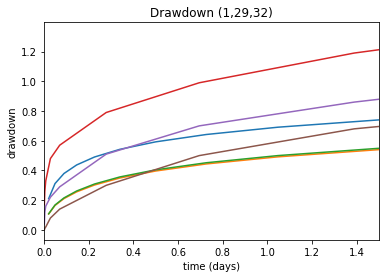

In [138]:
# Plot the drawdown versus time
plt.subplot(1, 1, 1)
ttl = 'Drawdown ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 
plt.plot(ts[:, 0], 0-ts[:, 1:]) #(x, y, color/type of line)
plt.plot(well_data2[:, 0], well_data2[:, 1:])
plt.xlim(0, ts[:, 0].max())
#plt.ylim(0, (0-ts[:, 1:]).max())



<a list of 0 text.Text objects>

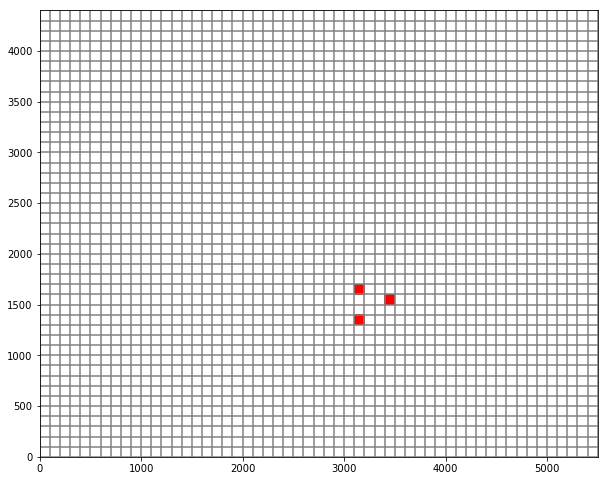

In [159]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()
riv = modelmap.plot_bc('RIV', color='b', plotAll=True)
quadmesh = modelmap.plot_bc('WEL', kper=1, plotAll=True)
contour_set = modelmap.contour_array(head, levels=np.arange(0, 36, 1), colors='g')
plt.clabel(contour_set, inline=1, fontsize=14)

In [160]:
fname = os.path.join(model_ws, 'p19.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')
fff = cbb.get_data(text='FLOW FRONT FACE')

rflow = cbb.get_data(text='RIVER LEAKAGE') #create an array/for loop to get out first value of every step
#cbb.list_records()

#create new list
rlist=[]

#create for loop to store only the first value of each time step from riv_flow into riv_list
for riv in rflow:
    rlist.append(riv['q'][0])
    
print(rlist)

Exception: The specified text string is not in the budget file.

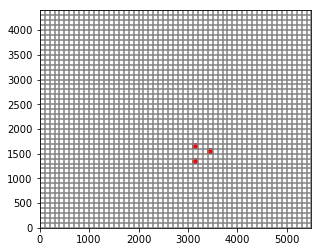

In [161]:
#create grid using model map
mm=flopy.plot.ModelMap(model=mf)
mm.plot_grid()
mm.plot_bc('WEL')

AttributeError: 'list' object has no attribute 'shape'

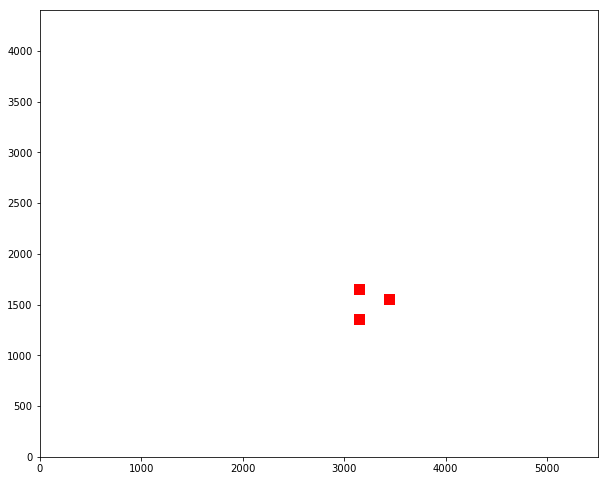

In [143]:
#plot arrows (quivers) that point in the direction of water flowb
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.ModelMap(model=mf)
modelmap.plot_bc("WEL")
quadmesh = modelmap.plot_ibound()
quiver = modelmap.plot_discharge(frf, fff, color='b')
linecollection = modelmap.plot_grid()

In [144]:
head

array([[[-0.00045144, -0.00046256, -0.0004849 , ..., -0.00196247,
         -0.0019093 , -0.00188258],
        [-0.00045969, -0.00047112, -0.0004941 , ..., -0.00201459,
         -0.00195906, -0.00193116],
        [-0.00047619, -0.00048824, -0.0005125 , ..., -0.00211941,
         -0.00205911, -0.00202882],
        ..., 
        [-0.00221481, -0.0022952 , -0.00245816, ..., -0.01387773,
         -0.01318675, -0.01284267],
        [-0.0021989 , -0.00227809, -0.00243857, ..., -0.01363614,
         -0.01297035, -0.0126386 ],
        [-0.00219076, -0.00226934, -0.00242855, ..., -0.01351315,
         -0.01286012, -0.01253462]]], dtype=float32)